In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from neurodyn import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_tufte import *
setup()

## coarse-graining neural fields

In order to simulate the neural field numerically, we discretize by taking a grid of $4^n$ samples in the $[0,1]^2$ space. (see ``manuscript/draft.md``)

$$
\int_{[0,1]^2} w_U(\vec v, \vec u) \phi(h_U(t, \vec u)) \mathrm d \vec u \rightarrow \sum_{j=1}^N \underbrace{w_U(\vec u_i, \vec u_j)}_{J_{ij}} \phi(\underbrace{h_U(t, \vec u_j)}_{h_j(t)})
$$

Each sample therefore corresponds to a population (density) indexed by $i = \{1\cdots4^n\}$. Population $i$ interacts with other populations through the (numerically finite) connectivity $J_{ij}$

To simulate the neural field in $[0,1]$, we take these populations use the mapping $S(\vec u_i) \stackrel{\text{notation}}= S(i) = \alpha_i$ to embed them in 1D.

One trivial mapping would be $S(i) = i / 4^n$, which is just ordering the populations in the order they appear inside the samples. More elaborate mappings are simply *permutations* of the numerically sampled populations set $\{1\cdots4^n\}$, and the resulting connectivity matrix is then given by $J_{S(i),S(j)}$ [^1].

However, the connectivity matrix is invariant to permutations of neurons (the numerical ordering is not important), and the dynamics are the same.

In the same way that discretizing the smooth 2D field works *because of* the smoothness, we consider the $4^n$ mapped populations $\alpha_i$ to be the "mathematically exact" 1D field ; and we "discretize" the 1D field by taking a grid of $2^n$ samples in $[0,1]$. In effect, we average bins of $2^n$ populations, in order to obtain $4^n/2^n = 2^n$ coarse-grained populations in $[0,1]$. We call this "downsampling" [^2].

The main question is now, what conditions must be imposed on the mapping (numerically : a permutation) $S : [0,1]^2 \rightarrow [0,1]$, such that it is *resilient* to this downsampling, in other words that the dynamics obtained from the connectivity in 1D are the same as the dynamics in 2D [^3].

In the following, this assertion is made by comparing the trajectories $(m_0(t),m_1(t))$ in phase space (also called latent space). If the mapping is "resilient", small differences between the trajectories vanish as $n \rightarrow \infty$ [^4].

[^1] : I am glossing over the details of how we sample the grid of $4^n$ elements in $[0,1]^2$ space. Numerically, there is an order in which we enumerate each of the $4^n$ samples (the most obvious is column-wise enumeration, i.e. ``ReshapeMapping.inverse_samples()``). As described, this ordering is abitrary, and one should always consider the enumeration of the samples to be in random order.

[^2] : The reason for which we take bins of size $2^n$, is because $2^n$ is the maximum size a bin can have which spans in only one direction in the 2D embedding. For instance, with the ``ReshapeMapping`` a column contains $2^n$ populations, all with the same $\xi_0$ position : visually the bin is vertical. With the ``DiagonalMapping``, the largest sequence of populations which "go in the same direction" (TODO : clarify this) is of size $2^n$, and spans the diagonal (1,0)->(0,1). Intuitively, this averaging can be seen as "destroying fast and large oscillations".

[^3] : The connectivity $\tilde J_{\alpha\beta}$ in 1D can be obtained by computing the "average low-rank vectors". See ``draft.md`` for more details.

[^4] : Each point in $(m_0,m_1)$ fully encodes the state of a linear low-rank RNN. We can prove (see my own handwritten notes) that $m_\mu(t) \approx \kappa_\mu(t)$ when $\phi(h)$ is close to linear. In our case, $\phi(h)$ is a sigmoid (I found a sigmoid has better convergence properties than a linear function), and can be considered linear as long as $-3 \lesssim h(t) \lesssim 3$.

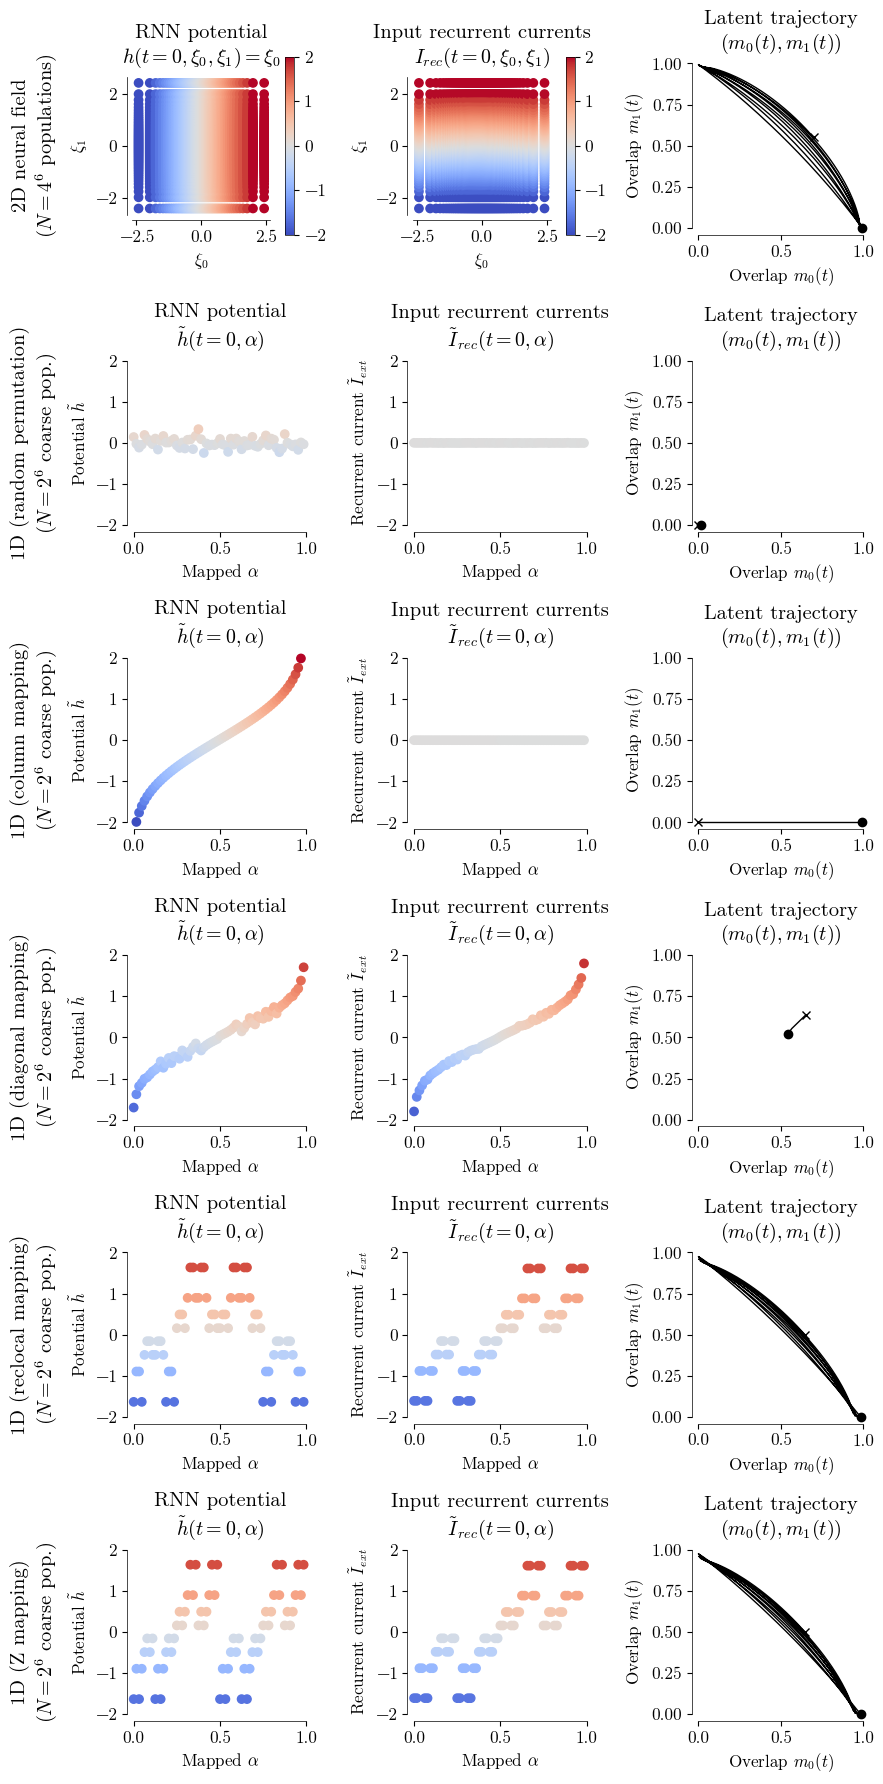

In [5]:
nrec = 6

rnns = {
	f'2D neural field\n($N=4^{nrec}$ populations)': LowRankCyclingRNN.new_sampled_valentin(
		# NOTE : we use inverse samples from reshape mapping here,
		# but the specific mapping is not important, since we are not downsampling,
		# and that the connectivity matrix is permutation invariant
		mapping_samples=ReshapeMapping.new_nrec(nrec).inverse_samples(),
		phi=sigmoid,  I_ext=zero, exclude_self_connections=False,
		delta=10, shift=1
	),
	f'1D (random permutation)\n($N=2^{nrec}$ coarse pop.)': LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
		mapping_samples=RandomMapping.new_nrec(nrec).inverse_samples(),
		phi=sigmoid,  I_ext=zero, exclude_self_connections=False,
		delta=10, shift=1
	).downsampled()),
	f'1D (column mapping)\n($N=2^{nrec}$ coarse pop.)': LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
		mapping_samples=ReshapeMapping.new_nrec(nrec).inverse_samples(),
		phi=sigmoid,  I_ext=zero, exclude_self_connections=False,
		delta=10, shift=1
	).downsampled()),
	f'1D (diagonal mapping)\n($N=2^{nrec}$ coarse pop.)': LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
		mapping_samples=DiagonalMapping.new_nrec(nrec).inverse_samples(),
		phi=sigmoid,  I_ext=zero, exclude_self_connections=False,
		delta=10, shift=1
	).downsampled()),
	f'1D (reclocal mapping)\n($N=2^{nrec}$ coarse pop.)': LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
		mapping_samples=RecursiveLocalMapping.new_nrec(nrec).inverse_samples(),
		phi=sigmoid,  I_ext=zero, exclude_self_connections=False,
		delta=10, shift=1
	).downsampled()),
	f'1D (Z mapping)\n($N=2^{nrec}$ coarse pop.)': LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
		mapping_samples=ZMapping.new_nrec(nrec).inverse_samples(),
		phi=sigmoid,  I_ext=zero, exclude_self_connections=False,
		delta=10, shift=1
	).downsampled())
}

fig, axes = plt.subplots(ncols=3, nrows=len(rnns), figsize=(3*3, len(rnns)*3))

for ax, (i, (name, rnn)) in zip(axes, enumerate(rnns.items())):
	res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 100))
	rnn.h_lagging = lambda t, h: h  # HACK : make recurrent current work for t=0

	if i == 0:
		im = ax[0].scatter(rnn.F[:, 0], rnn.F[:, 1], c=rnn.F[:, 0], cmap='coolwarm', vmin=-2, vmax=2)
		plt.colorbar(im, ax=ax[0])
		im = ax[1].scatter(rnn.F[:, 0], rnn.F[:, 1], c=rnn.I_rec(0, rnn.F[:, 0]), cmap='coolwarm', vmin=-2, vmax=2)
		plt.colorbar(im, ax=ax[1])
		ax[0].set_title('RNN potential\n$h(t=0, \\xi_0, \\xi_1)=\\xi_0$')
		ax[1].set_title(f'Input recurrent currents\n$I_{{rec}}(t=0,\\xi_0,\\xi_1)$')
		ax[0].set_xlabel('$\\xi_0$')
		ax[0].set_ylabel('$\\xi_1$')
		ax[0].set_aspect('equal')
		ax[1].set_xlabel('$\\xi_0$')
		ax[1].set_ylabel('$\\xi_1$')
		ax[1].set_aspect('equal')
	else:
		ax[0].scatter(np.arange(len(rnn.F)) / len(rnn.F), rnn.F[:, 0], c=rnn.F[:, 0], cmap='coolwarm', vmin=-2, vmax=2)
		ax[1].scatter(np.arange(len(rnn.F)) / len(rnn.F), rnn.I_rec(0, rnn.F[:, 0]), c=rnn.I_rec(0, rnn.F[:, 0]), cmap='coolwarm', vmin=-2, vmax=2)
		ax[0].set_title('RNN potential\n$\\tilde h(t=0, \\alpha)$')
		ax[1].set_title('Input recurrent currents\n$\\tilde I_{{rec}}(t=0,\\alpha)$')
		ax[0].set_xlim((0,1))
		ax[0].set_ylim((-2,2))
		ax[0].set_xlabel('Mapped $\\alpha$')
		ax[0].set_ylabel('Potential $\\tilde h$')
		ax[1].set_xlim((0,1))
		ax[1].set_ylim((-2,2))
		ax[1].set_xlabel('Mapped $\\alpha$')
		ax[1].set_ylabel('Recurrent current $\\tilde I_{{ext}}$')

	plot_overlap_phase2D(rnn, res, figax=(fig, ax[2]))
	ax[2].set_title('Latent trajectory\n$(m_0(t), m_1(t))$')
	breathe(ax[0])
	breathe(ax[1])
	breathe(ax[2])

add_headers(axes=axes.flat, row_headers=list(rnns.keys()), fontsize='large', row_pad=20)

plt.show()

TODO : might be interesting to plot the evolution of the potential and recurrent current in 3D (imshow) : (alpha, time, potential(time, alpha))